## 결정 트리

### 먼저 로지스틱회귀를 통해 시도를 해본다.
- 선형회귀와 로지스틱회귀의 차이점
- https://chatgpt.com/c/67db8929-9d28-8011-8cd3-df6bd6e97b62

In [95]:
import pandas as pd
wine = pd.read_csv("https://bit.ly/wine_csv_data")
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [96]:
# info() 메서드: 데이터프레임의 각 열의 데이터 타입과 결측치 확인에 유용
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [97]:
# describe() 메서드: 열에 대한 간략한 통계를 보여줌
# 최소, 최대, 평균값 확인 가능
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [101]:
# 특성과 결과값 분할
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine[['class']].to_numpy()

In [103]:
# 훈련과 테스트 세트 분할
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, random_state=42)

In [105]:
print(train_input.shape, test_input.shape)

(4872, 3) (1625, 3)


In [107]:
# 전처리(표준화)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [109]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7859195402298851
0.7655384615384615


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- 로지스틱 회귀를 학습해 나온 결과를 설명하는것은 학습 계수와 절편으로는 설명하기 힘들다.

## 결정트리
- 트리 구조를 이용해 데이터를 분류하거나 예측하는 지도 학습 알고리즘이다.
- if-else 규칙을 기반으로 작동하고, 머신러닝에서 자주 사용한다. =
- 모델의 결과가 나온 이유를 설명하기 쉽다.

In [114]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

# 훈련 점수는 높지만 테스트 점수가 낮음 -> 과소적합

0.9973316912972086
0.8516923076923076


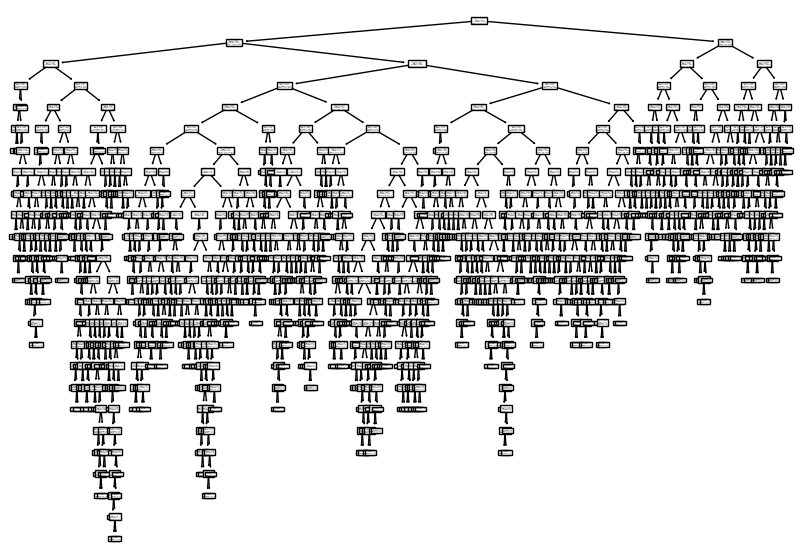

In [116]:
# 결정 트리의 그림 출력
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

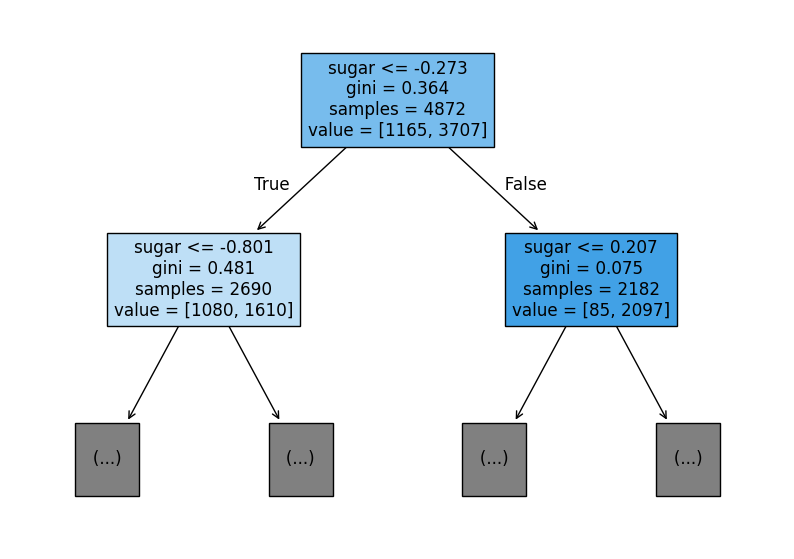

In [117]:
# 너무 복잡하므로 깊이를 제한해서 출력해보자
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

## 해석
- 먼저 value = `[`1165, 3707`]`는 음성 샘픔(0, 레드와인)과 양성 샘플(1, 화이트와인)을 의미한다.
- 루트 노드는 당도가 -0.273 이하인지 질문, 성립하면 왼쪽, 성립하지 않으면 오른쪽이다.
- 오른쪽 노드의 양성 샘플이 음성 샘플보다 훨씬 많은것을 볼 수 있다. -> 당도에 따라 양성과 음성 샘플이 분류된것.
  - filled=True를 통해 어떤 클래스 비율이 높아지면 점점 진한색으로 표시

### 불순도
- gini는 지니 불순도를 의미한다.
- DecisionTreeClassifier 클래스의 criterion 매개변수 기본값이 gini이다.
  - criterion 매개변수란?: 노드에서 데이터를 분할할 기준을 정한다.
- 즉 지니 불순도를 기준으로 노드를 나눌지를 결정하는것이다.
  - 지니 불순도가 낮아지는 방향으로 데이터를 나눔

### 지니 불순도 계산
- 지니불순도 = 1 - (음성 클래스 비율^2 + 양성 클래스 비율^2)
  - 1 - ((1258 / 5197)^2 + ((3939 / 5197)^2) = 0.367
- 만약 두 클래스의 비율이 정확히 1/2씩이면 불순도는 0.5 -> 최악
- 만약 노드에 하나의 클래스만 있다면 불순도는 0 -> 순수 노드

### 결정 트리 모델의 특성 
- 부모 노드와 자식 노드의 불순도 차이가 가능한 크도록 트리를 성장시킨다.
  - 이러한 불순도 차이를 정보 이득이라고 부른다.
- criterion=entropy로 엔트로피 불순도를 사용할 수 있다.
- 노드를 순수하게 나눌수록 정보 이득이 커진다. 그리고 마지막에 도달한 노드의 클래스 비율을 보고 예측을 만든다.
  - 앞의 트리는 제한 없이 자라나 훈련 세트의 점수가 너무 높게 나오고, 테스트 데이터의 점수가 크게 낮았다. -> 가지치기

## 가지치기
- 가지치기를 하지 않으면 무작정 끝까지 학습하는 트리 모델이 생성된다.
- 그렇게 된다면 훈련세트만 너무 최적으로 학습하므로 테스트 세트에서 점수는 그에 못미칠것이다.
- max_depth 매개변수를 이용해 최대 깊이를 지정할수 있다.

In [123]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8499589490968801
0.8363076923076923


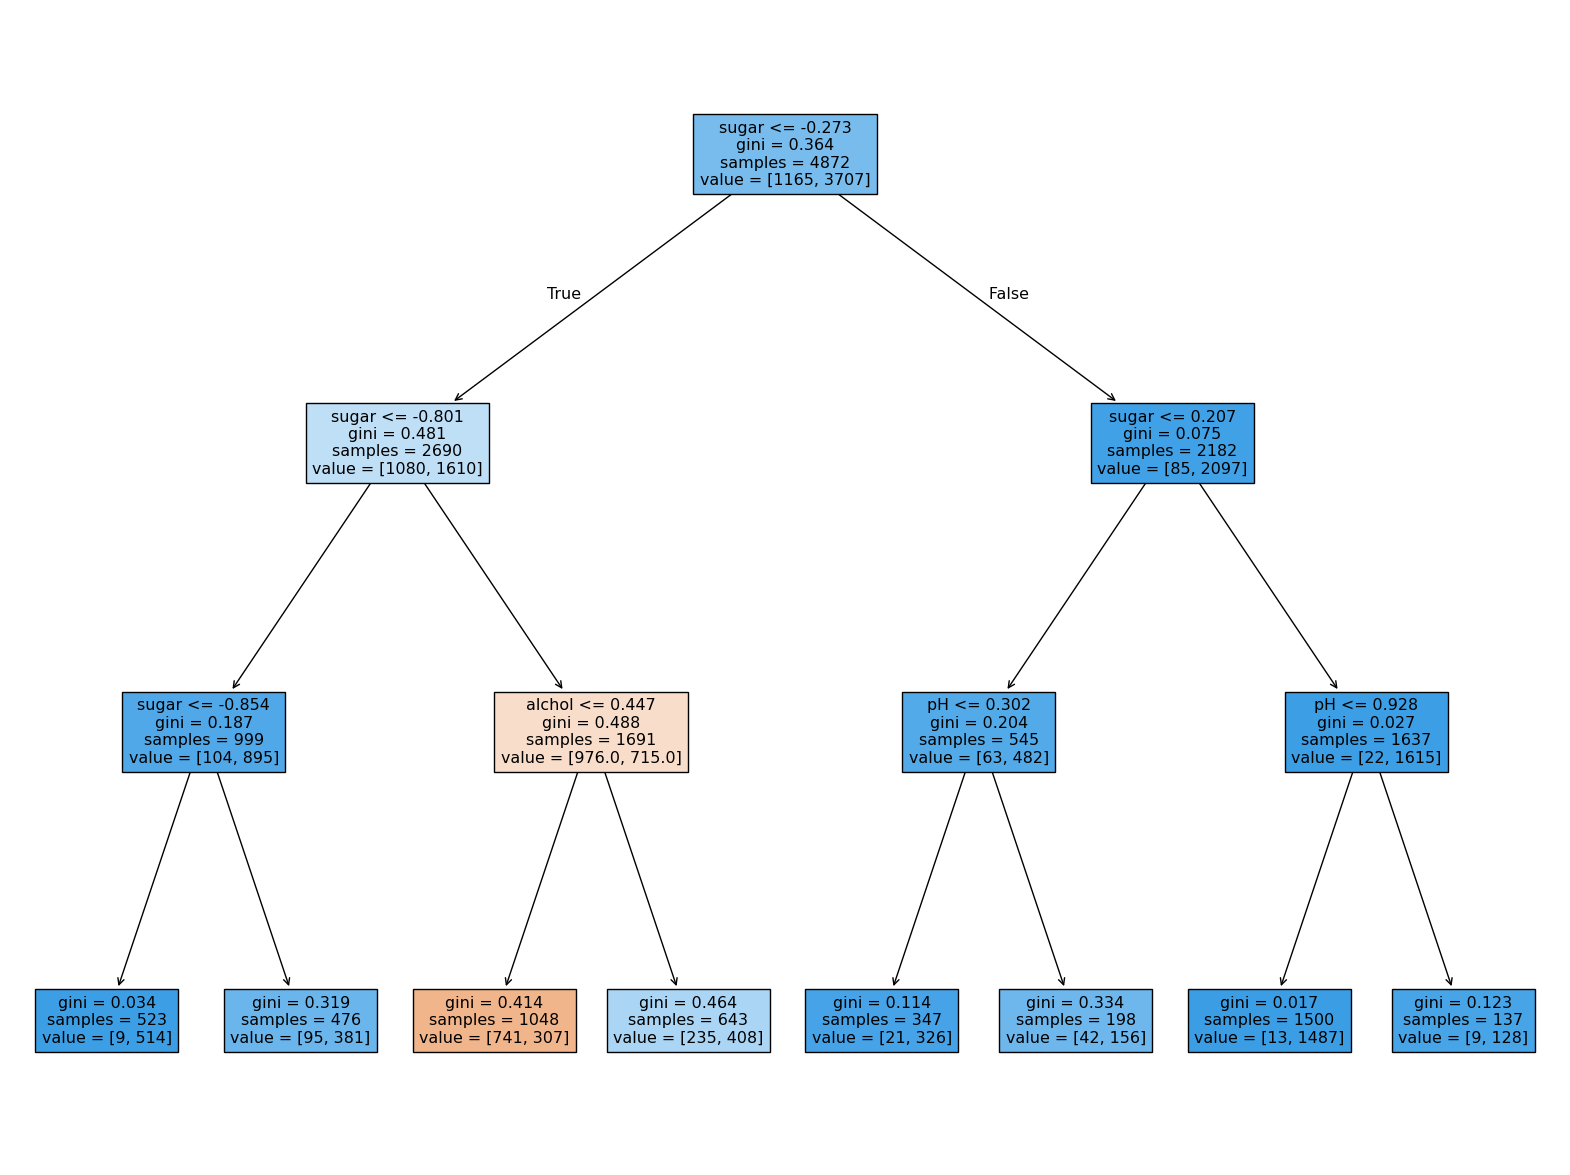

In [125]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

0.8499589490968801
0.8363076923076923


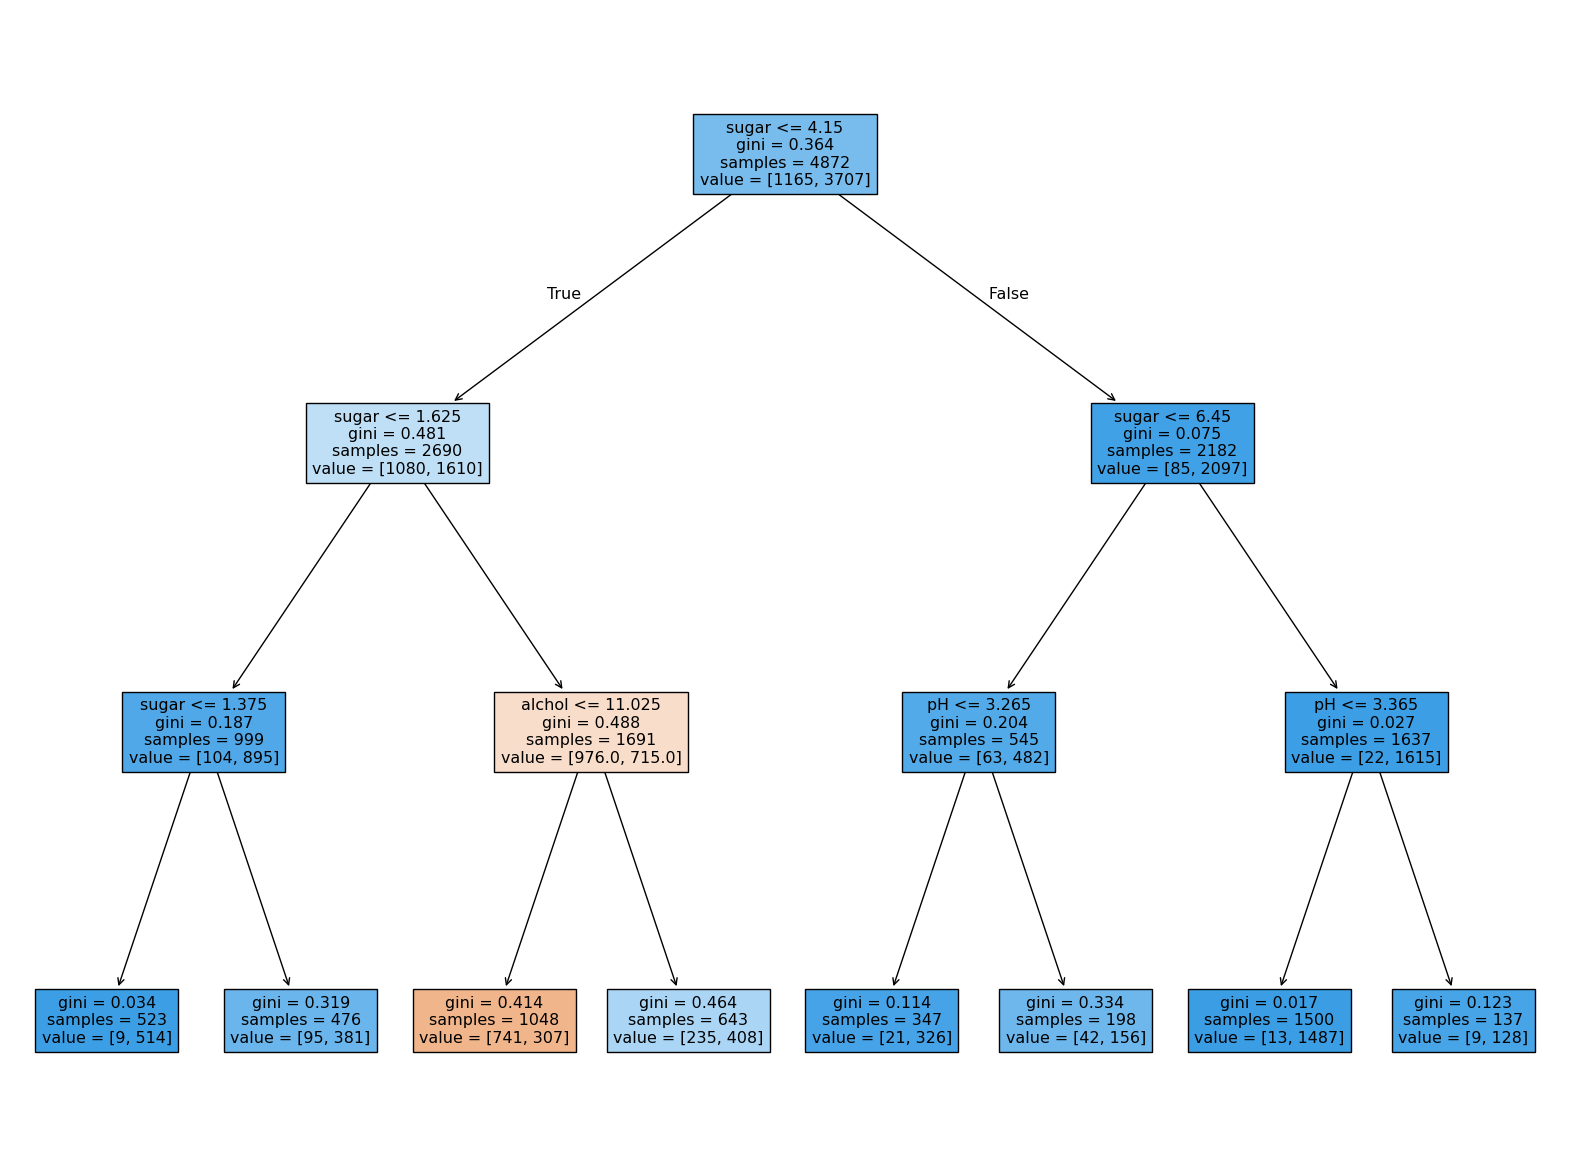

In [131]:
# 결정트리는 표준화가 필요 없다.
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

# 값을 나누는 단위가 표준화 전으로 돌아가 더욱 직관적이다.

In [132]:
# 결정 트리의 특성 중요도 확인
print(dt.feature_importances_)
# alcohol, sugar, ph순서	 

[0.12871631 0.86213285 0.00915084]
